<a href="https://colab.research.google.com/github/dmarinere/Team_Egypt_Corona/blob/master/Team_Egypt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to quantify the statistical significance of a public health policy introduced by African governments to slow down the spread of COVID-19.
In this Analysis, the goal is to understand the impact of Government interventions and forecasting COVID-19 Cases in Egypt. This task will aim to extend the paper ['The SIR Model for Spread of Disease']('https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model') to our target country **EGYPT**

##  Table of Content 

1. [Installing and importing important library](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=SbcloOmXn7QK&line=1&uniqifier=1)

2. [Data Retrieval](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=SbcloOmXn7QK&line=1&uniqifier=1)

3. [Data Preprocessing](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=WnNQvf3RMFL6&line=2&uniqifier=1)
4. [Splitting our Dataset](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=ny59Nb7VGUCt&line=7&uniqifier=1)

5. [Introducing Policies](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=XQt0w0QzN8cL&line=1&uniqifier=1)
6. [Validating our Model and plotting](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=dyDWMMQEifrp&line=1&uniqifier=1)

7. [Prediction Plot](https://colab.research.google.com/drive/1oEFgEA4H3qF3Hwe4k9VYIrtNOYkYO4IB#scrollTo=S6IihZRNw2n-&line=1&uniqifier=1)

# Importing Libraries 

#### We first have to import the latest version of **PYMC3** and also the **COVID-19** Library that are essential for this analysis

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git
!pip install git+https://github.com/pymc-devs/pymc3

Then we import the libraries we just download and other important libraries that are essential


In [ ]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az
import covid19_inference as cov19
import pickle 
import warnings
warnings.filterwarnings('ignore')


# 2. Data retrieval

The next thing we want to do is load a dataset from reliable data sources.
There are multiple authentic data sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the JHU dataset, which comes from the John Hopkins University, we would use the COVID19 library for this. 


In [ ]:
jhu = cov19.data_retrieval.JHU()  # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download so we could retrieve data as they are upload from our source

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


One could also parse True to the constructor of the class above to force an auto download so we could retrieve data as they are upload from our source

# 3. Data Preprocessing 




We can now access this downloaded data by the attribute that we are looking for and also in this case the specific country which is **Egypt** using some functions and filters that come with the JHU 


you can learn more about the different filter methods [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).



We start with by filtering the time range we need to use for the analysis we would start from the first confirmed COVID19 case in  which was **14 February 2020**

In [ ]:
bd = datetime.datetime(2020, 2, 14)  # For the date filter from first confirmed case
ed = datetime.datetime.now() #Till today

We then go ahead to retrieved the Total(Cumulative) number of confirmed cases and also the total number of new cases per day since this is possible and would make our analysis easier using the data we specified above.

In [ ]:
total_cases_obs = jhu.get_total(
    value="confirmed", country = 'Egypt', data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country = 'Egypt', data_begin=bd, data_end=ed
)

I want to start with understanding the data and the number of days with no cases.

In [ ]:
nonew_cases= new_cases_obs[new_cases_obs == 0]

In [ ]:
nonew_cases

date
2020-02-15    0
2020-02-16    0
2020-02-17    0
2020-02-18    0
2020-02-19    0
2020-02-20    0
2020-02-21    0
2020-02-22    0
2020-02-23    0
2020-02-24    0
2020-02-25    0
2020-02-26    0
2020-02-27    0
2020-02-28    0
2020-02-29    0
2020-03-02    0
2020-03-03    0
2020-03-04    0
2020-03-07    0
2020-03-18    0
Name: confirmed, dtype: int64

> > We were told to look out for zeros in our number of cases but since i started my modelling from a 14th of March, there is only one zero to worry about which wouldn't affect our modelling and Prediction

I would start my analysis from the time that the total number of cases in Egypt got to 100 as this would be a Indication that it has gotten to the stage of community spread and according to the model which i would use for my analysis signify that it would grow exponential and can be predicted more accurately.

This would be done by specifying that for the total number of cases we are only date where the cases are greater than 100

 >> Here is an overview of the cases

In [ ]:
total_cases_obs

date
2020-02-14        1
2020-02-15        1
2020-02-16        1
2020-02-17        1
2020-02-18        1
              ...  
2020-08-03    94640
2020-08-04    94752
2020-08-05    94875
2020-08-06    95006
2020-08-07    95147
Name: confirmed, Length: 176, dtype: int64

It is clear from this that the cummulative number of cases currently is **94,875** at 5th of August 2020

We would print the shape and dimension of our data





In [ ]:
print("The Shape of total number of cases is", total_cases_obs.shape[0],
      "rows" )
print("The dimension of the total number of cases is",total_cases_obs.ndim)

The Shape of total number of cases is 176 rows
The dimension of the total number of cases is 1


This starts with removing any data that is less than 100 from the data set as explained previously, we would do this to both the total cases and the recorded daily cases

In [ ]:
total_cases_obs =total_cases_obs[total_cases_obs > 99 ]
total_cases_obs

date
2020-03-14      109
2020-03-15      110
2020-03-16      150
2020-03-17      196
2020-03-18      196
              ...  
2020-08-03    94640
2020-08-04    94752
2020-08-05    94875
2020-08-06    95006
2020-08-07    95147
Name: confirmed, Length: 147, dtype: int64

using the day before the number of cases were greater than 100 which was **13-3-2020** we would retrieve only cases after that day also for new cases dataset

In [ ]:
new_cases_obs = new_cases_obs[new_cases_obs.index > '2020-03-13']
new_cases_obs

date
2020-03-14     29
2020-03-15      1
2020-03-16     40
2020-03-17     46
2020-03-18      0
             ... 
2020-08-03    157
2020-08-04    112
2020-08-05    123
2020-08-06    131
2020-08-07    141
Name: confirmed, Length: 147, dtype: int64

#Splitting our the dataset




We would split our dataset into training and test as was specified in the instruction given     
**Training set**    
Includes all dates from the time the community transmission reaches 100 to July 25 2020.   
**Validation set**   
Includes dates from 25 July 2020 to one final date in the covid19 cases data.  


In [ ]:
#days before 25 of July we had already dealt with community transmission earlier
train_total =  total_cases_obs[total_cases_obs.index < '2020-07-25']
train_new = new_cases_obs[new_cases_obs.index < '2020-07-25']

#days after 24th of july this would be used for the validation to compare 
#our prediction
test_total =  total_cases_obs[total_cases_obs.index > '2020-07-24']
test_new =  new_cases_obs[new_cases_obs.index > '2020-07-24']

# Plot the training data together

>    ### Sorry 
 > > ### We have to create a model first
# Creating a model 

No no no, we can't jump to this now, we would have to start with specifying the different parameters, modelling our data and getting samples and prediction before we can even begin to plot anything,
We would start from trying to create a model





In [ ]:
train_total

date
2020-03-14      109
2020-03-15      110
2020-03-16      150
2020-03-17      196
2020-03-18      196
              ...  
2020-07-20    88402
2020-07-21    89078
2020-07-22    89745
2020-07-23    90413
2020-07-24    91072
Name: confirmed, Length: 133, dtype: int64

# Find the dates where your country introduced the following policies.

The model parameters would be specified for different points, in my data we specified three different Change point where the government annouced some policies that we think were important to the trajectory of Coronavirus
> 1. School closures and some work restrictions when the cummulative cases were 100 :   **March 15**
> 2. Stay at Home and serious restrictions to religious gathering et al. 
cummulative cases were 900 :   **March 26**
> 3. Reopening of the Economy in Egypt for Tourist : **July 1**

 > > We would be focusing on just this different change point we want to see how this affected the COVID-19 Spread in Egypt. 



## Creating the model

First we need to set the priors for the change points and other configs.


In [ ]:
diff_data_sim = 10  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 15)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 26)
prior_date_reopen_ban_begin = datetime.datetime(2020, 7, 1)


In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_reopen_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=1,
     ),
]

In [ ]:
params_model = dict(
    new_cases_obs=train_new[:],
    #specifying when our data starts
    data_begin=datetime.datetime(2020, 3, 14),
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=98e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [ ]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(5, 6),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

In [ ]:
filename = "/content/drive/My Drive/Colab Notebooks/model/SIRMore.pickled"

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:
this_mode, trace = loaded_model[0], loaded_model[1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



## MCMC sampling(Marcov Chain Monte Carlo )

After the model is built and assigned different parameters, it is then sampled using an  [MCMC sampler](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).![MCMC Explained](https://github.com/fonnesbeck/mcmc_pydata_london_2019/raw/99aaa2350a57a8e4866cd5510b3c0c4f81c80647/notebooks/images/Metropolis.png)




The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time but we would reduce the run and sample for this analysis



In [ ]:
trace = pm.sample(model=this_model, tune=30, draws=100, init="advi+adapt_diag", cores = 16)

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 39700
INFO     [pymc3.variational.inference] Convergence achieved at 39700
Interrupted at 39,699 [19%]: Average Loss = 1,109.8
INFO     [pymc3.variational.inference] Interrupted at 39,699 [19%]: Average Loss = 1,109.8
Multiprocess sampling (16 chains in 16 jobs)
INFO     [pymc3] Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]


Sampling 16 chains for 30 tune and 100 draw iterations (480 + 1_600 draws total) took 6160 seconds.
INFO     [pymc3] Sampling 16 chains for 30 tune and 100 draw iterations (480 + 1_600 draws total) took 6160 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4106112640913276, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.4106112640913276, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increas

In [ ]:
path_save_pickled = "/content/drive/My Drive/Colab Notebooks/Week-3/Friday-Week3/"
pickle.dump([this_model, trace], open(path_save_pickled + 'SEIR.pickled', 'wb'))



# Plotting the Distribution of the posteriors and the priors 


### Distributions


This function helps us plot the distribution very easily

In [ ]:
def plot_distributions(model, trace, color=None):
    fig, axes = plt.subplots(6, 3, figsize=(6, 9.4))
    axes[0, 2].set_visible(False)
    axes[1, 2].set_visible(False)
    left_vars = ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
    mid_vars = ["offset_modulation","sigma_obs","I_begin","transient_day_1","transient_day_2","transient_day_3"]
    right_vars =  ["delay", "transient_len_1", "transient_len_2", "transient_len_3"]

    for i, key in enumerate(left_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 0], color=color)

    for i, key in enumerate(mid_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i, 1], color=color)

    for i, key in enumerate(right_vars):
        cov19.plot._distribution(model, trace, key, ax=axes[i+2, 2], color=color)

    fig.tight_layout()

def plot_results(model, trace):
    plot_distributions(model, trace)


Here we would try to understand the mean and standard deviation of our parameter and also the Rhat also help us understand how well our model is doing, the farther it is from 1.00 the more careful we should be, we would need more time to train our model to get perfect score for the rhat.

In [ ]:
pm.summary(trace, varnames=['lambda_0','lambda_1', 'lambda_2','transient_day_1','transient_day_2',
  'transient_len_1', 'transient_len_2', 'I_begin', 'delay',
 'weekend_factor', 'sigma_obs'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_0,0.331,0.170,0.106,0.631,0.016,0.012,107.0,107.0,89.0,295.0,1.13
lambda_1,0.241,0.049,0.151,0.321,0.006,0.004,76.0,76.0,74.0,118.0,1.15
lambda_2,0.183,0.021,0.143,0.222,0.003,0.003,37.0,35.0,40.0,32.0,1.32
transient_day_1,10.345,3.145,5.405,16.488,0.385,0.274,67.0,67.0,70.0,137.0,1.16
transient_day_2,22.307,1.419,19.847,25.108,0.101,0.072,196.0,196.0,188.0,1049.0,1.20
transient_len_1,4.081,2.253,1.116,8.208,0.123,0.087,335.0,335.0,209.0,209.0,1.12
transient_len_2,4.883,2.687,1.177,9.834,0.154,0.109,303.0,303.0,206.0,275.0,1.15
I_begin,55.133,68.749,0.018,170.912,6.971,4.944,97.0,97.0,74.0,114.0,1.15
delay,16.336,2.236,12.240,20.628,0.201,0.143,124.0,123.0,132.0,169.0,1.08
weekend_factor,0.110,0.026,0.066,0.158,0.003,0.002,79.0,79.0,81.0,732.0,1.13


This would help anyone seeing this understand a litle about how our model is structure and how some parameters connect

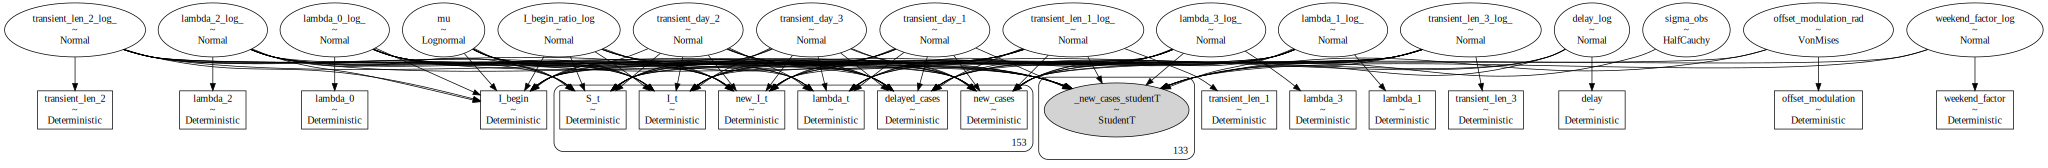

In [ ]:
from pymc3 import model_to_graphviz

model_to_graphviz(this_model)

We would see here that the model has not been stabilized to make very accurate prediction, this is because we do not have sufficient resource to carry out the prediction for that time range currently, as it would take days, to do a more wholistic analysis, it is trying to form a distribution but has not yet been able to, because we didn't give it enough time

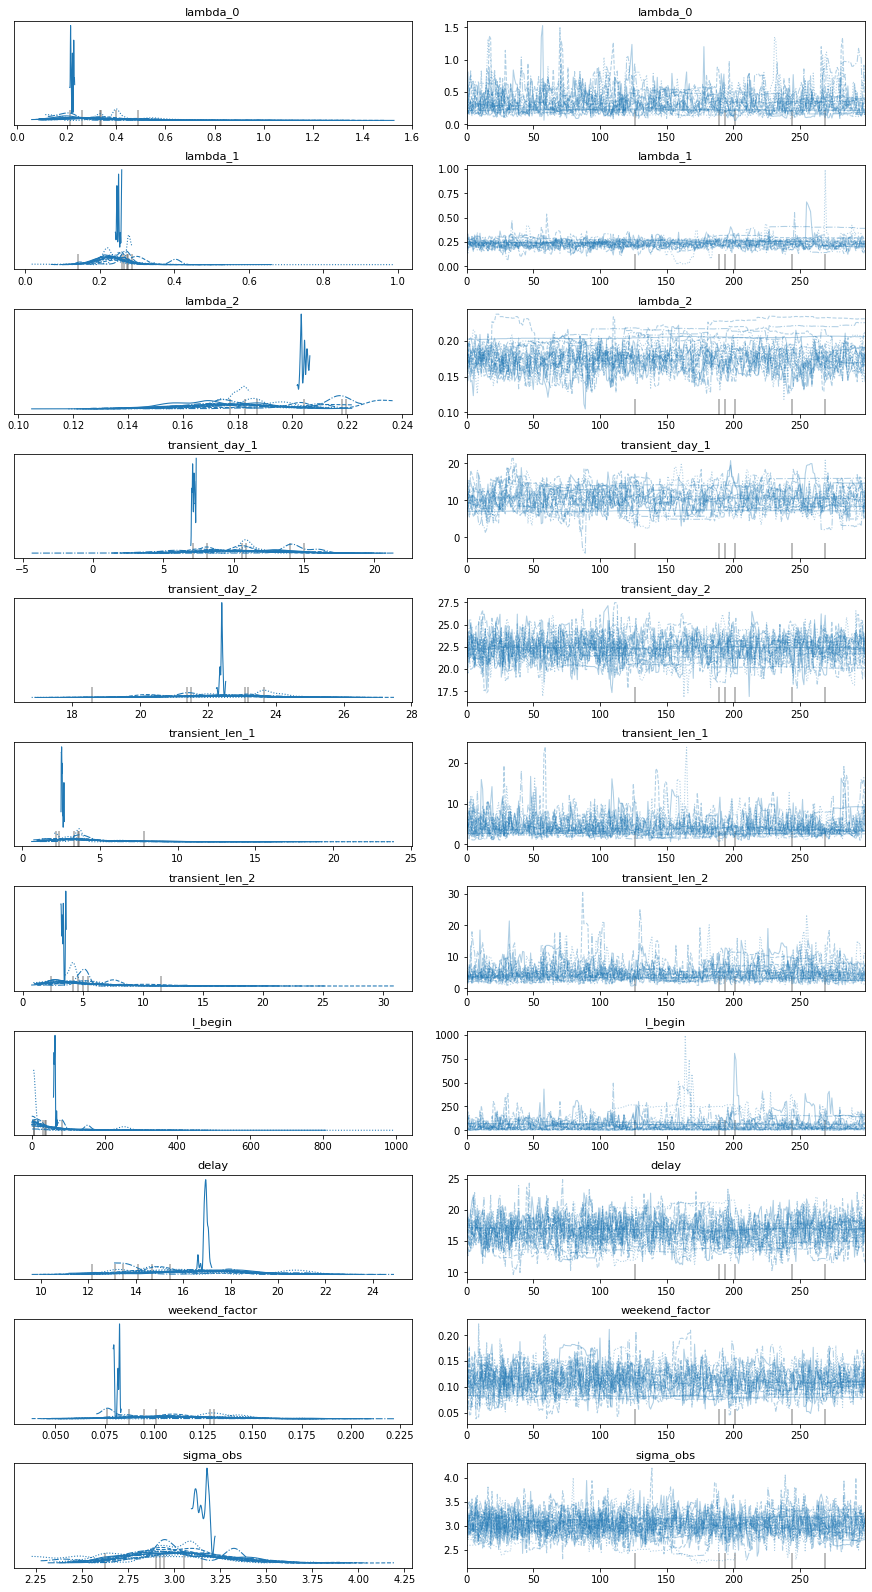

In [ ]:
pm.traceplot(trace,  varnames=['lambda_0','lambda_1', 'lambda_2','transient_day_1','transient_day_2',
  'transient_len_1', 'transient_len_2', 'I_begin', 'delay',
 'weekend_factor', 'sigma_obs'] );

Here we plot results from our Analysis, this shows fitted our model is to the sample 




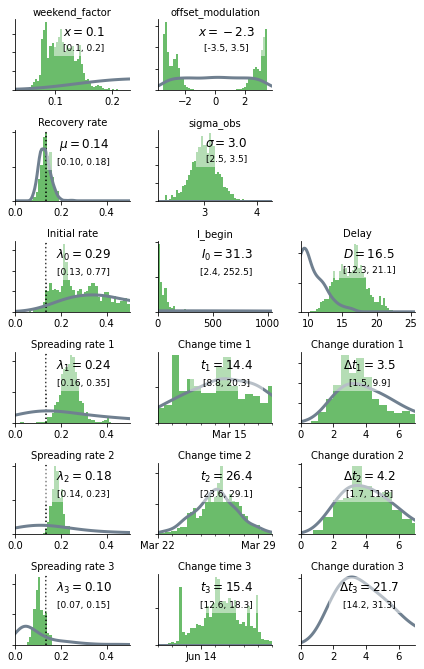

In [ ]:
plot_results(model=this_model, trace=trace)


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


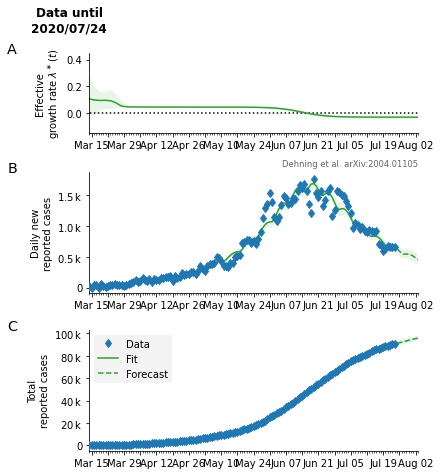

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace)


# Our Validation and Plot

In [ ]:
y_fcast, x_fcast = cov19.plot._get_array_from_trace_via_date(
        this_model, trace, "new_cases", this_model.fcast_begin, this_model.fcast_end
    )

Here is our First Prediction while testing the data, we would compare this to the original data, since our model account for unreported values we would say this may be a near accurate analysis

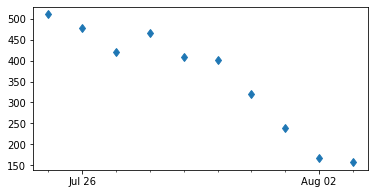

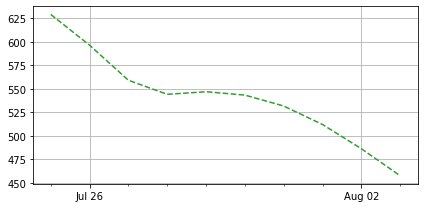

In [ ]:
cov19.plot._timeseries(test_new[:10].index, test_new[:10], what="data")
cov19.plot._timeseries(x_fcast, y_fcast[0], what="fcast")
plt.tight_layout()
plt.grid(True)

> >There is a similar patteren in both the test and the predict but the predictions seems to catch up slowly.

I added some change point to this to make the prediction more accurate

> Here we are trying to predict for future day till 10th of August 



In [ ]:
prior_date_reopen_begin3 = datetime.datetime(2020, 7, 1)

In [ ]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_reopen_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 12,
        pr_sigma_lambda=1,
     ),
    dict(
      pr_mean_date_transient=prior_date_reopen_begin3,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=1,
     ),
]

In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    #specifying when our data starts
    data_begin=datetime.datetime(2020, 3, 14),
    fcast_len=10,
    diff_data_sim=diff_data_sim,
    N_population=98e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10

Creating and specifying the model Parameters

In [ ]:
with cov19.model.Cov19Model(**params_model) as fore_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(5, 6),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  

In [ ]:
trace2 = pm.sample(model=fore_model, tune=30, draws=100, init="advi+adapt_diag", cores = 16)

In [ ]:
#save our model so we can use it again for future analysis
path_save_pickled = "/content/drive/My Drive/Colab Notebooks/model/"
pickle.dump([fore_model, trace2], open(path_save_pickled + 'SIR3.pickled', 'wb'))


In [ ]:
filename ="/content/drive/My Drive/Colab Notebooks/model/SIR3.pickled"
my_model = pickle.load(open(filename, 'rb'))

In [ ]:
fore_model, trace2 = my_model[0], my_model[1]

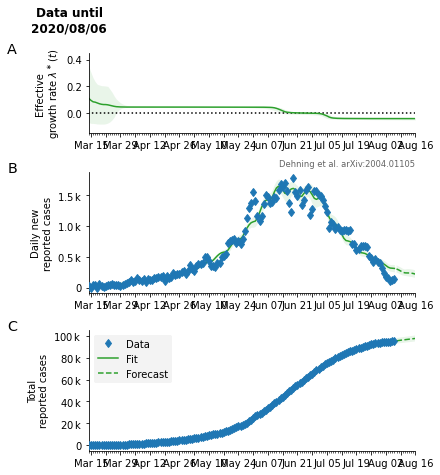

In [ ]:
fig, axes = cov19.plot.timeseries_overview(fore_model, trace2)

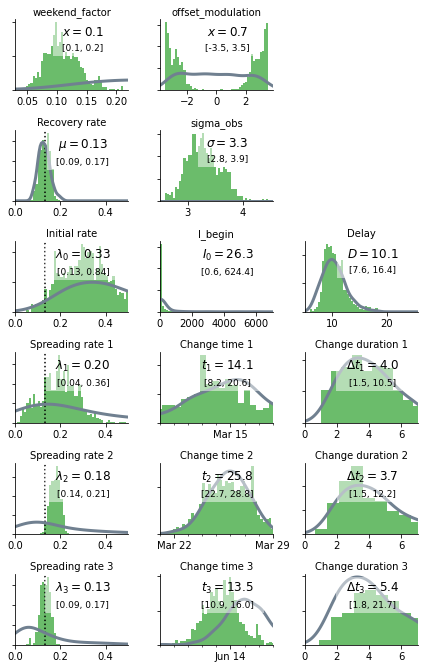

In [ ]:
plot_results(model=fore_model, trace=trace2)

Predicted cases for next week for egypt 

In [ ]:
y_fcast, x_fcast = cov19.plot._get_array_from_trace_via_date(
        fore_model, trace2, "new_cases", fore_model.fcast_begin, fore_model.fcast_end
    )

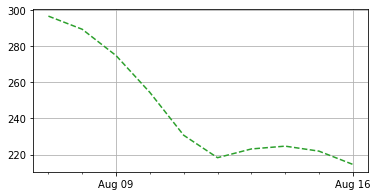

In [ ]:
cov19.plot._timeseries(x_fcast, y_fcast[0], what="fcast")
plt.grid(True)